# DS3000 Day 15

Nov 9/10, 2023

Admin
- Qwickly Attendance (PIN on board)
- Homework 4 (Last Homework!) due **Nov 21**
  - The *plan* is for you to be able to do everything on the homework after **today**
  - Part 1.4: I never taught you how to do matrix inverses by hand, so just use `numpy` for finding the inverse. All other work on that problem should be done by hand. (I've added a pushup below for this)
- Quiz 3 done by next Tuesday, **Nov 14**
- Visitor Updates:
  - Confirmed Qi Wang, Meta for **Nov 21**
  - Working on getting Ryan Murpy, Finra for **Nov 14**

Push-Up Tracker
- Section 04: 8
- Section 05: 10
- Section 06: 8

Content:
- Multiple Regression
- Polynomial Regression

In [1]:
# packages for today
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import plotly.express as px
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import math
from scipy.stats import norm 
import scipy.stats as stats
import pylab as py

## Previously: Intro to Regression

Previously, we saw this overview of Machine Learning and introduced the first **regression** algorithm, **simple linear regression**:

|                          | Input Features per sample | Output Features per sample | Supervised | Penguin Example                                                                       |
|:------------------------:|:-------------------------:|:--------------------------:|:----------:|---------------------------------------------------------------------------------------|
|           Classification | 1+ numerical features     | one categorical feature    | True       | Given `topspeed`, `totaltorque` estimate `drive`                         |
|               Regression | 1+ numerical features     | one continuous feature     | True       | Given `topspeed`, `totaltorque` estimate `batterycapacity`                   |
|               Clustering | 1+ numerical features     | one categorical feature    | False      | Identify k groups of vehicles which have similar `topspeed`, `totaltorque` |
| Dimensionality Reduction | N numerical features      | < N numerical features     | False      | Find 2d vector which best represents all of the vehicles's features    |

## Simple Linear Regression Example

Can we predict a vehicle's `batterycapacity` given their `topspeed`?

In [2]:
df_ev = pd.read_csv('evdataset.csv', index_col='id')
df_ev.head()

drive  acceleration  topspeed  electricrange  totalpower  totaltorque  \
id                                                                           
1647  Rear           7.8       185            390         168          350   
1493   AWD           6.2       160            330         215          520   
1229   AWD           3.2       260            415         500          850   
1252  Rear           5.7       190            470         250          430   
1534  Rear           7.9       160            450         150          310   

      batterycapacity  chargespeed  length  width  height  wheelbase  \
id                                                                     
1647             77.4           49    4515   1890    1580       2900   
1493             69.7           46    4684   1834    1701       2829   
1229             93.4           46    4963   1966    1381       2900   
1252             83.9           54    4783   1852    1448       2856   
1534             82.0           55    4261   1809    1568       2771   

      grossweight  
id                 
1647         2495  
1493         2580  
1229         2880  
1252         2605  
1534         2300

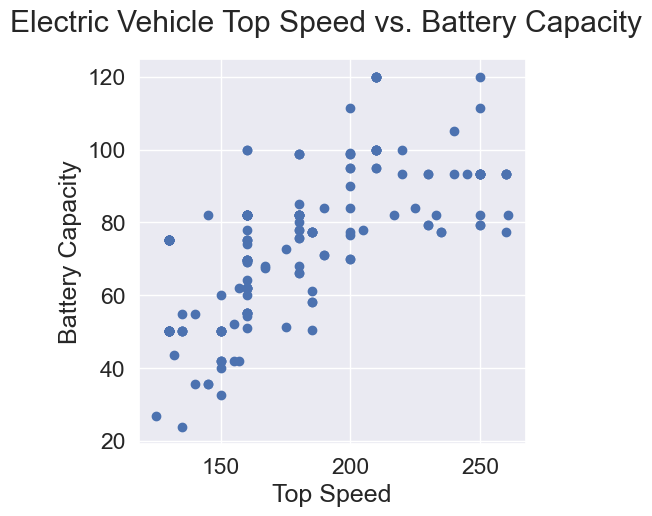

In [3]:
sns.set(font_scale=1.5)
plt.scatter(df_ev.topspeed, df_ev.batterycapacity)
plt.xlabel('Top Speed')
plt.ylabel('Battery Capacity')
plt.suptitle('Electric Vehicle Top Speed vs. Battery Capacity')
plt.gcf().set_size_inches(5, 5)

In [4]:
X = np.array([[1] * len(df_ev),
              df_ev.topspeed]).T
y = np.array(df_ev.batterycapacity)
b = np.matmul(np.linalg.inv(np.matmul(X.T, X)), np.matmul(X.T, y))
np.set_printoptions(suppress=True) #this just prevents python from printing it out in inconvenient scientific notation
b

array([11.9381054 ,  0.35093642])

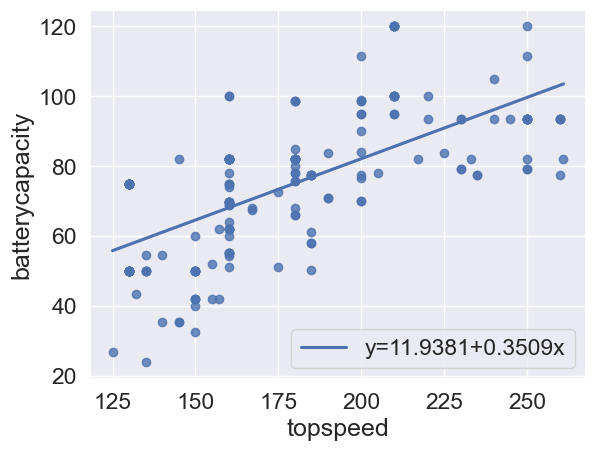

In [5]:
plot = sns.regplot(data=df_ev, x='topspeed', y='batterycapacity', fit_reg=True, ci=None, 
                   line_kws={'label':"y={1:.4f}+{0:.4f}x".format(0.3509,11.9381)});
plot.legend();

# Simple linear regression

The true relationship between $X$ and $y$ is described by:

$$y = X\beta + \varepsilon$$

And is estimated by the line:

$$\hat{y} = X\hat{\beta} = b_0 + b_1x$$

* $X$ is our input data/design matrix 
    - (column of 1's for the intercept and a column with the top speed of a vehicle)
* $y$ is the outcome we're predicting 
    - (battery capacity of a vehicle)
* $\beta$ is the true coefficients of the line, estimated by $\hat{\beta}$.
* $\hat{y}$ is the set of predictions for $y$ after fitting the model

$$X = \begin{bmatrix} 1 & 185 \\ 1 & 160 \\ \vdots & \vdots \end{bmatrix}$$
$$y = \begin{bmatrix} 77.4 \\ 69.7 \\ \vdots \end{bmatrix}$$

- The resulting **coefficient vector** from the line of best fit contains our intercept and slope: $(X^TX)^{-1}X^Ty = \hat{\beta} = \begin{bmatrix} b_0 \\ b_1 \end{bmatrix}$
- The predicted outcome, $\hat{y}$ is the **projection** of $y$ to the span of $X$: $\hat{y} = X\hat{\beta}$

## Comparing models

Since we could have multiple models for the same relationship, we should discuss two measures that are most common for evaluating how good a model is.

- Mean squared error, $MSE$
- Coefficient of determination, $R^2$

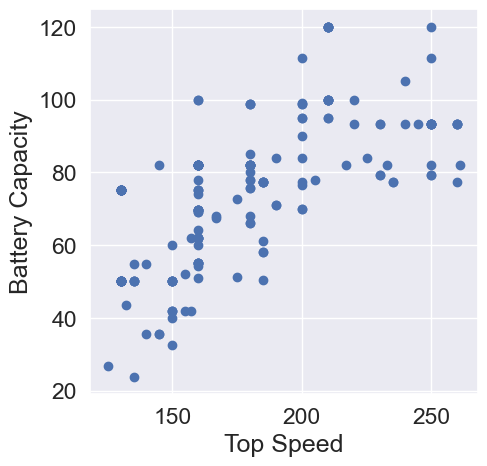

In [6]:
plt.scatter(df_ev.topspeed, df_ev.batterycapacity)
plt.xlabel('Top Speed')
plt.ylabel('Battery Capacity')
plt.gcf().set_size_inches(5, 5)

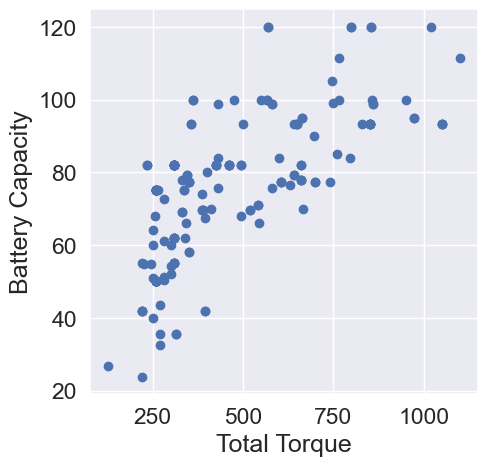

In [7]:
plt.scatter(df_ev.totaltorque, df_ev.batterycapacity)
plt.xlabel('Total Torque')
plt.ylabel('Battery Capacity')
plt.gcf().set_size_inches(5, 5)

In [8]:
# get the two different design matrices
XA = np.array([[1] * len(df_ev),
               df_ev.topspeed]).T
XB = np.array([[1] * len(df_ev),
               df_ev.totaltorque]).T
# get the outcome vector
y = np.array(df_ev.batterycapacity)

# estimate the lines (get the coefficients)
bA = np.matmul(np.linalg.inv(np.matmul(XA.T, XA)), np.matmul(XA.T, y))
bB = np.matmul(np.linalg.inv(np.matmul(XB.T, XB)), np.matmul(XB.T, y))

# get the predictions
yhatA = np.matmul(XA, bA)
yhatB = np.matmul(XB, bB)

# get the residuals
eA = y - yhatA
eB = y - yhatB

So, how do we compare? The first thing we'll do is calculate:

## Mean Square Error, $MSE$

- MSE measures how closely a line (i.e. $b_1, b_0$) comes to all observations $(x, y)$
- MSE is 0 when the line goes through all points exactly
- MSE is large when the line is far from many pairs $(x, y)$

**The best fit line $(b_1, b_0)$ is the one which minimizes MSE**

$$
    MSE = \frac{1}{n}\sum_{j} {(y_j - \hat{y}_j)^2} = \frac{1}{n} \sum_{j} e_{j}^2
$$

In [9]:
def get_mse(y_true, y_pred):
    # calculate the mean squared distance between the predicted and actual y
    return np.mean((y_pred - y_true) ** 2)

In [10]:
# MSE of top speed model for battery capacity
get_mse(y, yhatA)

224.8861278426953

In [11]:
# MSE for total torque model for battery capacity
get_mse(y, yhatB)

197.64839825507065

Thus, for our two models:

$$MSE_A = 224.886$$
$$MSE_B = 197.648$$

Implies that `totaltorque` does a better job of predicting `batterycapacity` than `topspeed` does!

## $R^2$ is the percentage of variance of y can be explained by the model

$$R^2 = 1-\frac{MSE}{\sigma_y^2}$$

$R^2$ is the percent of variance of $y$ explained by $X$ (under model; also called the **coefficient of determination**)

Intuition:
- $R^2 = 0$
    - $X$, using this model, doesn't explain any of the variance of $y$
- $R^2 = .5$
    - $X$, using this model, explains half the variance of $y$
- $R^2 = 1$
    - $X$, using this model, explains all the differences in $y$

In [12]:
mse_A = get_mse(y, yhatA)
mse_B = get_mse(y, yhatB)

r2A = 1 - (mse_A/y.var())
print(r2A)
r2B = 1 - (mse_B/y.var())
print(r2B)

0.44174132650435205
0.5093564299101818


In [13]:
# or, using sklearn (note some slight rounding issues...)
from sklearn.metrics import r2_score

print(r2_score(y, yhatA))
print(r2_score(y, yhatB))

0.44174132650435194
0.5093564299101818


## More Considerations

We talked about how above there were two key things we needed to consider:

- **Cross Validation**: the goal is to predict **new** observations, so why aren't we cross validating?? We definitely need to, to make sure that our results are generalizable. In fact, instead of comparing the $R^2$ for the full models above, we should really be generating our $\hat{y}$ values through cross validation before comparing $R^2$.
- **Correlation implies Linearity**: Which means, in simple **line**ar regression, if we don't have a linear relationship, $R^2$ is **misleading**. This actually leads us to:
  - **Assumptions of Linear Regression**: whenever we conduct a linear regression, we are making some assumptions which can be summarized in terms of the errors/residuals. To be confident that the model is even appropriate to use, we should make sure that:
    - The residuals seem to be **independent** (i.e. that observations close to each other don't have systematically similar residuals)
    - The residuals seem to **constantly varying** (i.e. that no matter what the $x$ feature value is, the residuals seem to be vary equally)
    - The residuals seem to be **normally distributed** (i.e. that most residuals are around 0, and that there are an equal number above and below zero, according to a normal curve)
    - And, **most importantly** that the relationship is *actually* linear.
   
To illustrate all these things, we'll also establish how to use `scikit-learn`'s function for this, `LinearRegression`:

In [14]:
from sklearn.linear_model import LinearRegression

## Cross Validation

We did this last time; please reference Day14. We will make sure we continue to cross validate (using LOO-CV) as we continue with multiple and polynomial regression.

## Checking Assumptions

Remember, the key assumption we make for this simple model is that the relationship between $x$ and $y$ is linear, but then also that the residuals will behave a certain way. How can we check these? Let's start with **residual plots** which are used to check those first three assumptions:

- Independence
- Constant Variance
- Normality

## Checking Independence
We can check if the residuals are independent by plotting them in the order of the observations; if we see any patterns, it suggests there is some dependency between observations. Focusing on the `totaltorque` model since it was better:

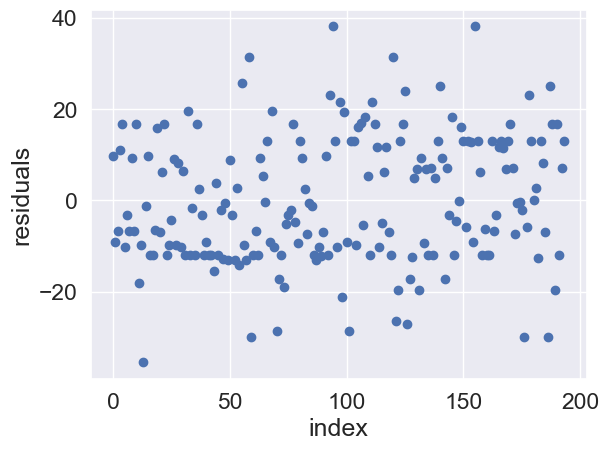

In [15]:
# plot a scatter plot of the errors in order
plt.scatter(x = range(len(y)), y = eB)
plt.xlabel('index')
plt.ylabel('residuals');

Hard to say sometimes if we see any patterns. There may be something going on where several residuals seem to be in a line between observations about 10-50 (and perhaps at a couple other places as well, like 150-200). This is a bit worrying, and would suggest we should look back at the data and think about this practically. Are the data in some order that suggests they may not be independent?

In [16]:
df_ev.head()

drive  acceleration  topspeed  electricrange  totalpower  totaltorque  \
id                                                                           
1647  Rear           7.8       185            390         168          350   
1493   AWD           6.2       160            330         215          520   
1229   AWD           3.2       260            415         500          850   
1252  Rear           5.7       190            470         250          430   
1534  Rear           7.9       160            450         150          310   

      batterycapacity  chargespeed  length  width  height  wheelbase  \
id                                                                     
1647             77.4           49    4515   1890    1580       2900   
1493             69.7           46    4684   1834    1701       2829   
1229             93.4           46    4963   1966    1381       2900   
1252             83.9           54    4783   1852    1448       2856   
1534             82.0           55    4261   1809    1568       2771   

      grossweight  
id                 
1647         2495  
1493         2580  
1229         2880  
1252         2605  
1534         2300

It's very hard to say, since we don't have any information about the specific vehicles (what's the make? the model? the year?) these things would be helpful to us in determining if there might be some dependence between the observations. As it stands, however, maybe it has something to do with Rear vs. AWD vs. Front, the drive type?

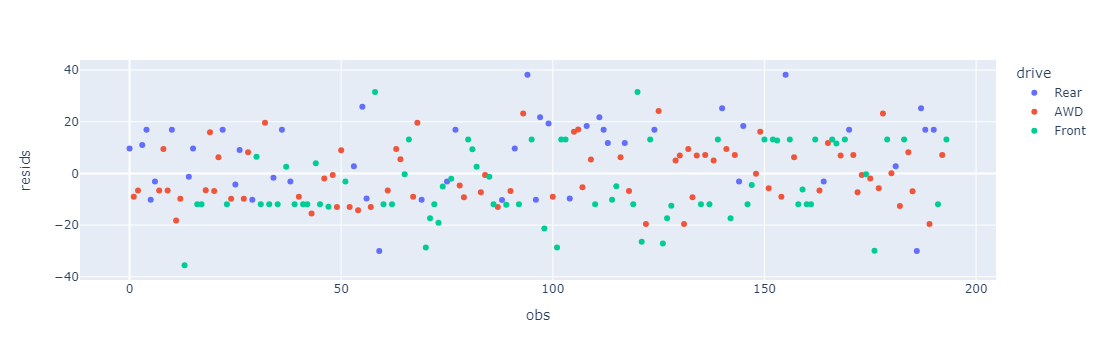

In [17]:
residB_df = pd.DataFrame({'obs': range(len(y)),
                          'drive': df_ev.drive,
                          'resids': eB})
px.scatter(residB_df, x = 'obs', y = 'resids', color = 'drive')

It does seem like the Front wheel drive vehicles are the source of much of the pattern we saw!

### How to fix?

It will depend on the situation. In this case, it might make sense to turn drive into dummy variables, and include them in a **multiple regression** (Right Now!).

## Checking Constant Variance
We can check if the errors vary constantly by plotting them over the values of our x-feature; if we see any patterns, especially curving or tunnel/funnel shapes, it suggests the variance is non-constant (or, also, that the relationship is not truly linear!)

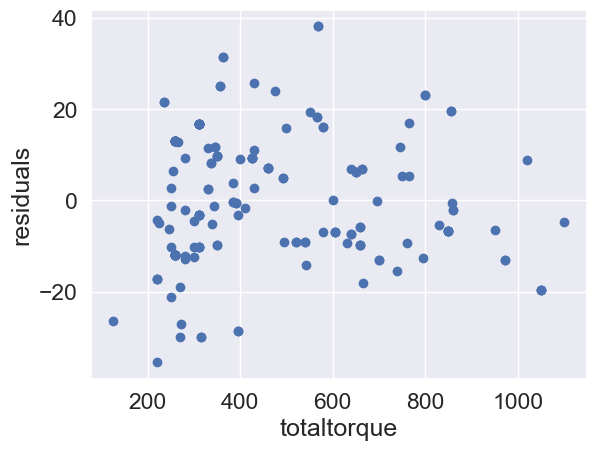

In [18]:
# plot a scatter plot of the errors over x
plt.scatter(x = XB[:,1], y = eB)
plt.xlabel('totaltorque')
plt.ylabel('residuals');

There seems to be a fairly random scatter as we move from left to right, without much curving/funneling/tunneling, though you could also argue that there is more variability in the residuals on the left than on the right.

### How to fix?

It is quite a bit harder to fix this issue when it arises; there are some more complicated ways to try to address it. One of the simpler ways is to **transform the y-feature**, but choosing what transformation to use is not trivial! We don't have time to discuss it in this class, but you may encounter it in the future. In some cases, for example when there is curving, it may also be fixed by including polynomial terms (**polynomial regression**, after multiple regression).

## Checking Normality
We can check if the errors are normally distributed by plotting their observed quantiles against the expected quantiles of a theoretical normal distribution; if we see an **approximately** straight, 45 degree line, it means our errors are normal, if it's really off, there's a problem!

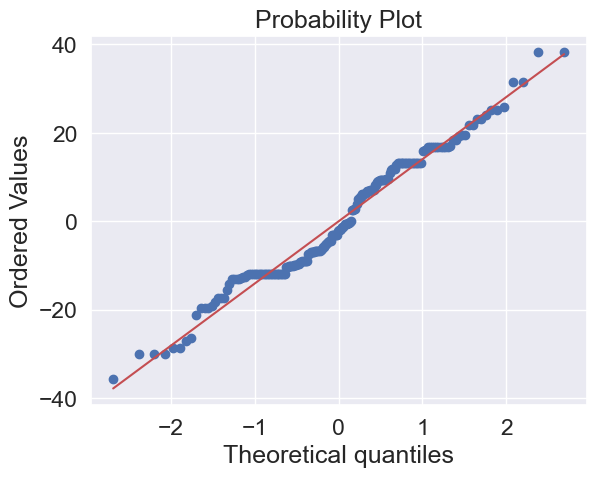

In [19]:
# the normal probability plot from last lecture notebook
stats.probplot(eB, dist="norm", plot=py)
py.show()

This may be a bit tricky to assess; my instinct tells me it's not too bad, though there is a bit of "wobbliness" (not a technical term, unfortunately) on the left side of the distribution.

### How to fix?

This can again be tricky. Transformations of the y feature may help again, or including more x features or polynomial features (multiple/polynomial regression), or changing the anticipated distribution of the y feature (**careful with this**, usually you want to think critically about what makes sense as a distribution for the outcome feature, if you are fitting a parametric model as we are. addressing this question is a bit beyond the scope of this course, but not too complicated to wrap your head around yourself). 

# Multiple Regression

In the first residual plot, we said that it would be nice to perhaps include `drive` as a feature (account for it) in the regression model with `totaltorque`. This means we'll be "adding" another $x$ feature to the model, and moving away from **simple** linear regression, to **multiple** linear regression.

## Using more than one x to predict a single y

How can we predict Battery Capacity using more than a single variable?

    Battery Capacity = b_0 + b_1 * Total Torque + b_2 * Top Speed + b_3 * Front + b_4 * Rear
    
Or even including any other features we want to include? We need to do **two things**:

- update our $X$ matrix with additional columns
- make sure all numeric features **are on the same scale**

The good news is that the linear algebra is exactly the same! In fact, we still write out the model the same way, using matrix notation:

$$y = X\beta + \varepsilon$$

Except now $$X$$ has more than two-columns, and $\beta$ is a vector equal in length to $p+1$ where $p$ is the number of $x$-features included in the model. The resulting best fit line is also written the same way:

$$\hat{y} = X\hat{\beta}$$



In [20]:
# add a column for Front wheel drive and for Rear wheel drive (0,0 would then indicate AWD)
drive_x = pd.get_dummies(df_ev.drive, drop_first = True, dtype = int).to_numpy()
scale_torque = (df_ev.totaltorque/df_ev.totaltorque.std()).to_numpy()
scale_tspeed = (df_ev.topspeed/df_ev.topspeed.std()).to_numpy()

In [21]:
X_mult = np.hstack((np.array([1]*len(y)).reshape(-1,1), scale_torque.reshape(-1,1), scale_tspeed.reshape(-1,1), drive_x))
print(X_mult.shape)
X_mult[0:4,:]

(194, 5)


array([[1.        , 1.57500568, 4.85434176, 0.        , 1.        ],
       [1.        , 2.34000844, 4.19834963, 0.        , 0.        ],
       [1.        , 3.8250138 , 6.82231815, 0.        , 0.        ],
       [1.        , 1.93500698, 4.98554018, 0.        , 1.        ]])

In [22]:
# do the thing
b = np.matmul(np.linalg.inv(np.matmul(X_mult.T, X_mult)), np.matmul(X_mult.T, y))
b

array([41.65318519, 12.30592448,  1.67965778, -4.55037801,  6.4311738 ])

What happened? Now we still have one intercept, but **four** slopes, one for `totaltorque`, one for `topspeed`, one for `front` wheel drive and one for `rear` wheel drive. 

## Interpretation

Interpretation becomes just a bit trickier in multiple regression, **especially with scaled and categorical features** like we've done here. Because all the $x$-features equalling zero now **means** something; it means we have a vehicle with 0 totaltorque and 0 topspeed **that is AWD**. This is called the **baseline** category, and now the intercept and the slopes are almost all in relation to that, plus the slopes are now all in terms of the scaled features:

- The intercept of 41.653 is the predicted battery capacity for an AWD vehicle with 0 total torque and 0 top speed
- The slope of 12.306 for total torque is how much the battery capacity increases when **scaled** total torque increases by 1, assuming the top speed and the drive of the vehicle are held fixed
- The slope of 1.68 for top speed is how much the battery capacity increases when **scaled** top speed increases by 1, assuming the total torque and the drive of the vehicle are held fixed
- The slope of -4.55 for front is how much battery capacity decreases for front wheel drive compared to AWD, assuming total torque and top speed are held fixed
- The slope of 6.43 for rear is how much battery capacity increases for rear wheel drive compared to AWD, assuming total torque and top speed are held fixed

However, aside from this interpretation difference (and a couple other points we'll mention shortly), much of the process of regression stays the same!

**Note**: when predicting a new observation, you want to make sure that you scale the $x$-features of the new observation(s) according to the original data set. I.e., if using scale normalization: $x_{new}^{scaled} = x_{new}/std(x_{old})$. For the purposes of cross validation, this is acheived simply by cross validating using the full scaled data set.

In [23]:
# cross validate to determine predictive ability of the model
# can use scikit-learn's LinearRegression for this too, just omit the bias column
X_mult[0,1:].reshape(-1,4)

array([[1.57500568, 4.85434176, 0.        , 1.        ]])

In [24]:
# set up the array of predictions to fill out
y_preds_mult = np.empty(len(X_mult))

# loop through each observation
for obs in range(len(X_mult)):
    # the below excludes the single row/true y belonging to obs as well as the bias column
    mult_trainX = np.concatenate((X_mult[:obs, 1:], X_mult[obs+1:, 1:]))
    mult_trainy = np.concatenate((y[:obs], y[obs+1:]))
    # then train the model
    loocv_regress = LinearRegression()
    loocv_regress.fit(mult_trainX, mult_trainy)
    # and predict the held out observation (and store it)
    y_preds_mult[obs] = loocv_regress.predict(X_mult[obs,1:].reshape(-1,4))[0]

r2_score(y, y_preds_mult)

0.539143255715427

Using both total torque and top speed, and including drive type improved our cross validated $R^2$ value! Did it also get rid of the dependence issue we'd seen? Check the assumptions again:

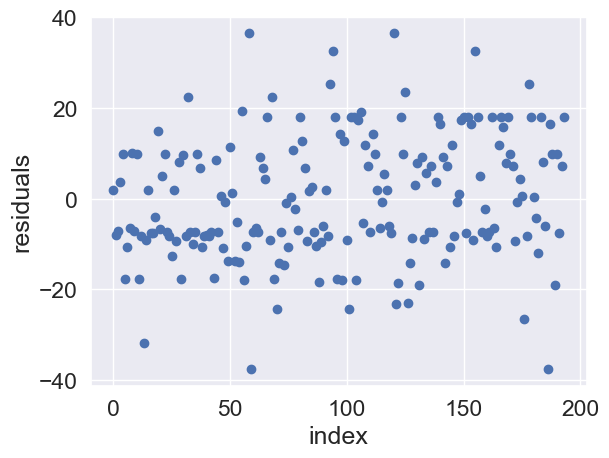

In [25]:
# plot a scatter plot of the errors in order
mult_resids = y - y_preds_mult
plt.scatter(x = range(len(y)), y = mult_resids)
plt.xlabel('index')
plt.ylabel('residuals');

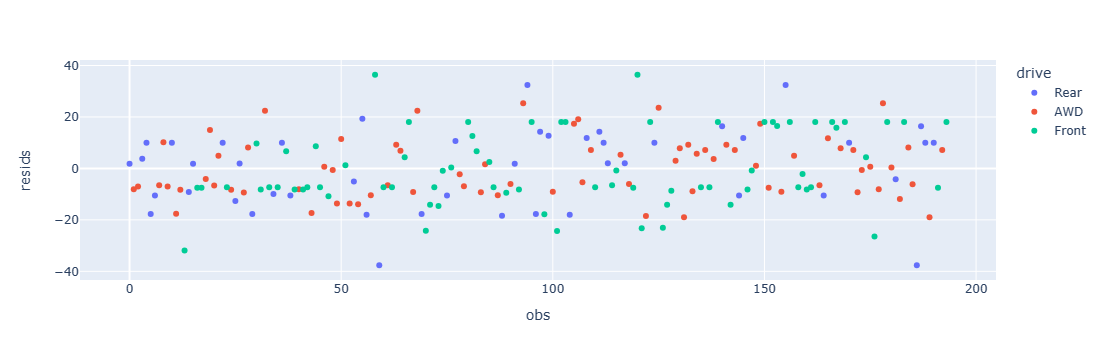

In [26]:
resid_mult_df = pd.DataFrame({'obs': range(len(y)),
                          'drive': df_ev.drive,
                          'resids': mult_resids})
px.scatter(resid_mult_df, x = 'obs', y = 'resids', color = 'drive')

Still not great! (Frustrating), but perhaps a *little* better, at least for that first "line" we saw (it's a bit more wobbly now). This likely means that there's yet something else we should be accounting for that we haven't been. There are plenty of features left to try! However, there is a danger to this...

## Adding more features to your model ...

- does not decrease $R^2$ (sounds good right??)
    - occasionally this means we may not be able to **trust** $R^2$, if we add a feature that is misleading to the model, $R^2$ will seem about the same or even better, despite the model being worse
    - we can instead use $Adjusted R^2$, which penalizes based on how many features we include
      - If the $Adjusted R^2$ is close to the full $R^2$, it means all the features are useful. If it is much lower, it suggests you've added a feature that is misleading.

In [27]:
import statsmodels.api as sm

# another way to fit the regression model so that we can get adjusted R^2 without having to calculate it manually
new_model = sm.OLS(y, X_mult).fit()

#display line and regular R2 (to verify same as before) and adjusted R-squared
print(new_model.params)
print(new_model.rsquared)
print(new_model.rsquared_adj)

[41.65318519 12.30592448  1.67965778 -4.55037801  6.4311738 ]
0.5618328838376629
0.5525595057178252


## Adding more features to your model ...
- can confuse the interpretation of your results
    - variance of x features impacts magnitude of coefficients, so we scale, but then the more scaled features we have, the more confusing things can get
- can cause models to not work at all, if we have more features than observations (big p, small n)

In [28]:
# an illustration of the big p, small n problem
# pretend you only have five cars, and let's not scale for the moment
df_ev_small = df_ev.iloc[0:5,:]
df_ev_small

drive  acceleration  topspeed  electricrange  totalpower  totaltorque  \
id                                                                           
1647  Rear           7.8       185            390         168          350   
1493   AWD           6.2       160            330         215          520   
1229   AWD           3.2       260            415         500          850   
1252  Rear           5.7       190            470         250          430   
1534  Rear           7.9       160            450         150          310   

      batterycapacity  chargespeed  length  width  height  wheelbase  \
id                                                                     
1647             77.4           49    4515   1890    1580       2900   
1493             69.7           46    4684   1834    1701       2829   
1229             93.4           46    4963   1966    1381       2900   
1252             83.9           54    4783   1852    1448       2856   
1534             82.0           55    4261   1809    1568       2771   

      grossweight  
id                 
1647         2495  
1493         2580  
1229         2880  
1252         2605  
1534         2300

In [29]:
# build a model for battery capacity using all the numeric features
X_bad = df_ev_small.iloc[:,[1,2,3,4,5,7,8,9,10,11,12]].to_numpy()
y_bad = df_ev_small.batterycapacity.to_numpy()
X_bad2 = np.hstack((np.array([1] * 5).reshape(-1,1), X_bad))

In [30]:
np.matmul(np.linalg.inv(np.matmul(X_bad2.T, X_bad2)), np.matmul(X_bad2.T, y_bad))

array([256.      , 104.      ,  -2.      ,  -0.5     ,   3.5     ,
        -1.25    ,  11.      ,  -0.015625,   0.125   ,  -0.4375  ,
        -0.171875,   0.125   ])

Hey, this seems like it worked! So what's so bad about it? Well, to illustrate the issue, let's simply switch the **order** of the features. In a proper setting, *this shouldn't matter*, since it is the same data set with the same features. However, when there are more features than observations, it turns out order matters:

In [31]:
# build a model for battery capacity using all the numeric features
X_bad = df_ev_small.iloc[:,[12,2,3,4,5,7,8,9,10,11,1]].to_numpy()
y_bad = df_ev_small.batterycapacity.to_numpy()
X_bad2 = np.hstack((np.array([1] * 5).reshape(-1,1), X_bad))

In [32]:
np.matmul(np.linalg.inv(np.matmul(X_bad2.T, X_bad2)), np.matmul(X_bad2.T, y_bad))

array([-128.   ,    0.125,   -2.   ,    1.   ,   -0.25 ,    0.5  ,
         -8.   ,   -0.125,   -0.125,   -0.25 ,    0.25 ,   18.   ])

This is directly tied to our discussion of linear dependence of vectors from before we started line of best fit. In any case, which is the correct model? It's impossible to say! When this happens, the model is **not identifiable**.  While we won't address how to solve the big p small n problem specifically in class, we have previously mentioned that **dimensionality reduction** and **regularization** could be used to help.

## Checking Assumptions in Multiple Regression

Still important, and still much the same, however since we have multiple $x$ features, we need to check multiple plots to assess constant variance/linearity: one for each $x$ feature. We already checked independence the same way (and saw that there was still some concern there...), so now we should create residual plots for each $x$ feature (including dummies) and the normal probability plot.

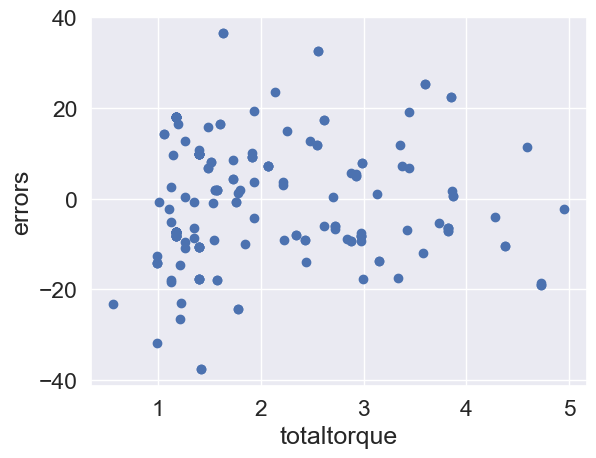

In [33]:
# check constant variance (total torque)
plt.scatter(x = X_mult[:,1], y = mult_resids)
plt.xlabel('totaltorque')
plt.ylabel('errors');

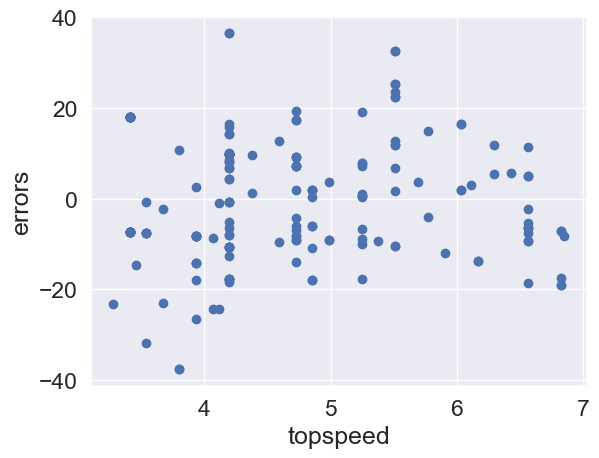

In [34]:
# check constant variance (top speed)
plt.scatter(x = X_mult[:,2], y = mult_resids)
plt.xlabel('topspeed')
plt.ylabel('errors');

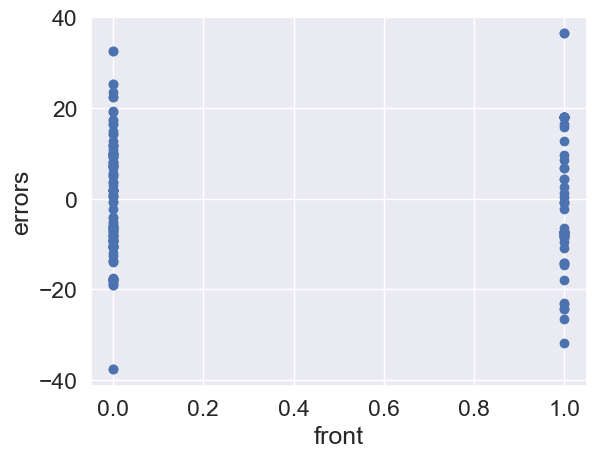

In [35]:
# check constant variance (front drive)
plt.scatter(x = X_mult[:,3], y = mult_resids)
plt.xlabel('front')
plt.ylabel('errors');

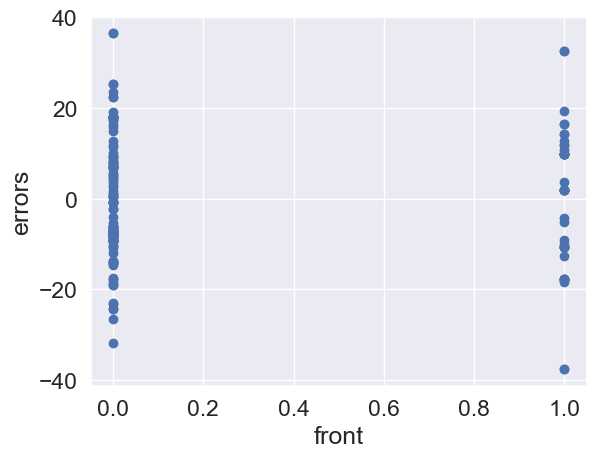

In [36]:
# check constant variance (rear drive)
plt.scatter(x = X_mult[:,4], y = mult_resids)
plt.xlabel('front')
plt.ylabel('errors');

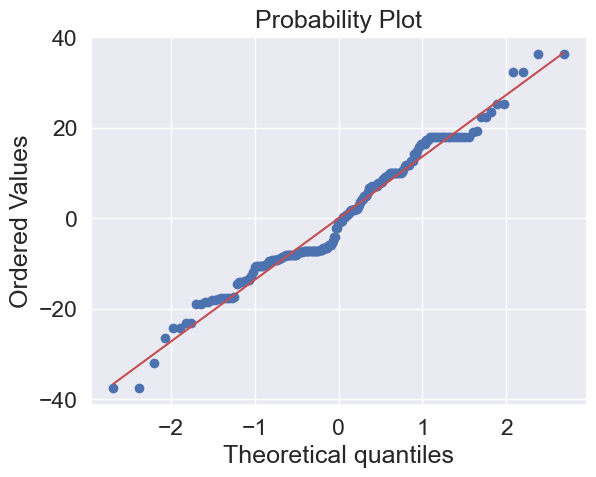

In [37]:
# check normality
stats.probplot(mult_resids, dist="norm", plot=py)
py.show()

Even though we've gotten a higher $R^2$ from this multiple regression model, it's hard to say whether it's actually any better than the original simple linear regression model with only total torque... There appears to still be some independence issues, and there's some curving in the plot for top speed which suggests that that relationship is not linear, and the normal probability plot actually looks a bit *worse*! It may be that we need to just continue considering the simple linear regression model as our best one.

### Or:

What about a non-linear model?

# What if we don't want a straight line model?
- polynomial regression

# Polynomial Regression

Occasionally, certain $x$-features do not have linear relationships with the outcome $y$ feature. Does this mean we can't use regression? No! It simply means we need to adapt our regression framework to allow for non-linear mappings of $x$ and $y$:

**Polynomial Regression Model:**
$$
y = b_0\cdot x^0 + b_1\cdot x^1 + b_2 \cdot x^2 + ... + b_n \cdot x^n
$$

This is actually a subset of multiple regression, where the polynomial terms are included additively. Hence, once again, all the linear algebra remains exactly the same!

Before implementing polynomial regression on a real data set, let's build a fake test set to establish the process with:

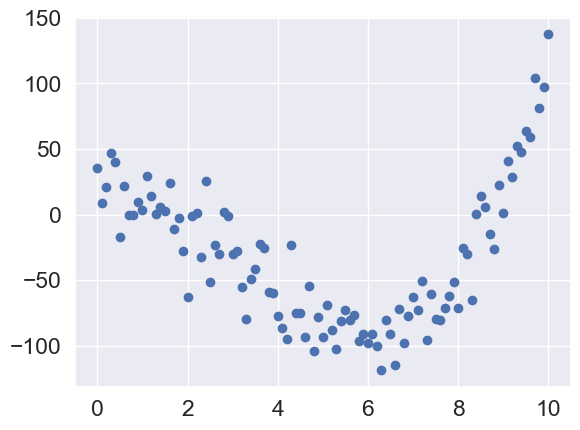

In [38]:
def coef_to_poly_str(coef, include_zero=False):
    """ creates a str of polynomial corresponding to coef    

    Args:
        coef (np.array): coefficients of polynomial
        
    Returns:
        poly_str (str): str of polynomial
    """
    
    str_monomial_list = []
    for deg, coef in enumerate(coef):
        if coef == 0 and include_zero == False:
            continue
        str_monomial_list.append(f'{coef:+.1f} x^{deg:d}')
        
    # handle case of all zero coef
    if len(str_monomial_list):
        poly_str = ' '.join(str_monomial_list)
    else:
        poly_str = '0'
        
    return f'y = {poly_str}'

def poly(x, coef):
    """ computes polynomials in x
    
    to represent the polynomial:
    
    b_0 x^0 + b_1 x^1 + b_2 x^2 + b_3 x^3 + ...
    
    coef = [b_0, b_1, b_2, b_3, ...]
    
    Args:
        x (np.array): input values
        coef (np.array): coefficients of polynomial
    """
    # initialize y as array of zeros
    y = np.zeros_like(x)
    
    # adds each monomial one at a time
    for deg, b in enumerate(coef):
        y += b * x ** deg
        
    return y 

def get_poly_data(coef, x_start=0, x_fin=10, n=101, noise=20):
    np.random.seed(0)
    x = np.linspace(x_start, x_fin, n)
    y = poly(x, coef) 
    
    # add some noise
    y = y + np.random.standard_normal(x.size) * noise
    
    # reshape into sklearn standard (n_samples, n_features)
    x = x.reshape(-1, 1)
    return x, y

# y = 0 x^0 + 10 x^1 - 10 x^2 + 1 x^3
coef = [0, 10, -10, 1]

x, y = get_poly_data(coef)
plt.scatter(x, y);

In [39]:
x[0:4,]

array([[0. ],
       [0.1],
       [0.2],
       [0.3]])

## The Design Matrix in Polynomial Regression

Notice that in the above (fake) situation, we still only have on $x$ feature and one $y$ feature. What does our design matrix $X$ look like? In simple linear regression, it would be:

$$X = \begin{bmatrix} 1 & 0 \\ 1 & 0.1 \\ 1 & 0.2 \\ \vdots & \vdots \end{bmatrix}$$

But we don't want to fit a straight line model to the data. Instead, we can think about the similarity between polynomial and multiple regression:

#### Polynomial Regression Model:
$$
y = b_0\cdot x^0 + b_1\cdot x^1 + b_2 \cdot x^2 + ... + b_n \cdot x^n
$$

where $x$ refers to the same input feature each time raised to a different power.

#### Multiple Regression Model:
$$
y = b_0\cdot x_0 + b_1 \cdot x_1 + b_2 \cdot x_2 + ... + b_n \cdot x_n
$$

where $x_i$ refer to distinct features.

## "tricking" model into looking at polynomial regression as multiple regression:

What if we "trick" sklearn's Linear Regression into thinking that higher order terms are new features.  That is, we'll set the "new" feature 
- $x_0$ as our single feature x raised the 0th power (always one; the bias term!)
- $x_1$ as our single feature x raised the 1st power
- $x_2$ as our single feature x raised the 2nd power
- $x_3$ as our single feature x raised the 3rd power
- etc.

Hence, the design matrix $X$ for the third degree polynomial fit to these data would look like:

$$X = \begin{bmatrix} 1 & 0 & 0 & 0 \\ 1 & 0.1 & 0.1^2 & 0.1^3 \\ 1 & 0.2 & 0.2^2 & 0.2^3 \\ \vdots & \vdots \end{bmatrix}$$

Luckily, instead of doing this manually, there's a convenient `sklearn` function for it:

In [40]:
from sklearn.preprocessing import PolynomialFeatures

degree = 3
poly_feat = PolynomialFeatures(degree=degree)
X_poly = poly_feat.fit_transform(x)

# examine polynomial features
X_poly[0:4]

array([[1.   , 0.   , 0.   , 0.   ],
       [1.   , 0.1  , 0.01 , 0.001],
       [1.   , 0.2  , 0.04 , 0.008],
       [1.   , 0.3  , 0.09 , 0.027]])

Now, we can do exactly what we've done before to get a "line" of best fit, but one that has polynomial terms and thus defines a non-linear function through the two dimensional vector space defined by $x$ and $y$:

In [41]:
# do the thing
b = np.matmul(np.linalg.inv(np.matmul(X_poly.T, X_poly)), np.matmul(X_poly.T, y))
b

array([19.94748128,  0.79358055, -9.47006266,  1.03916409])

## Interpretation

Interpretation is actually perhaps a bit simpler in this specific case than with multiple regression. When you are looking at a polynomial regression line from a single $x$ feature, there's no need to scale, and each "slope" details how the polynomial term of $x$ of that order impacts $y$. The intercept is interpreted as before:

- The intercept of 19.95 is the predicted $y$ when $x = 0$
- The slope of 0.79 is the linear term (order 1) for $x$'s impact on $y$
- The slope of -9.47 is the quadratic term (order 2) for $x$'s impact on $y$
- The slope of 1.04 is the cubic term (order 3) for $x$'s impacto on $y$

## Using those nice functions I wrote above to visualize the fit for a truly cubic relationship:

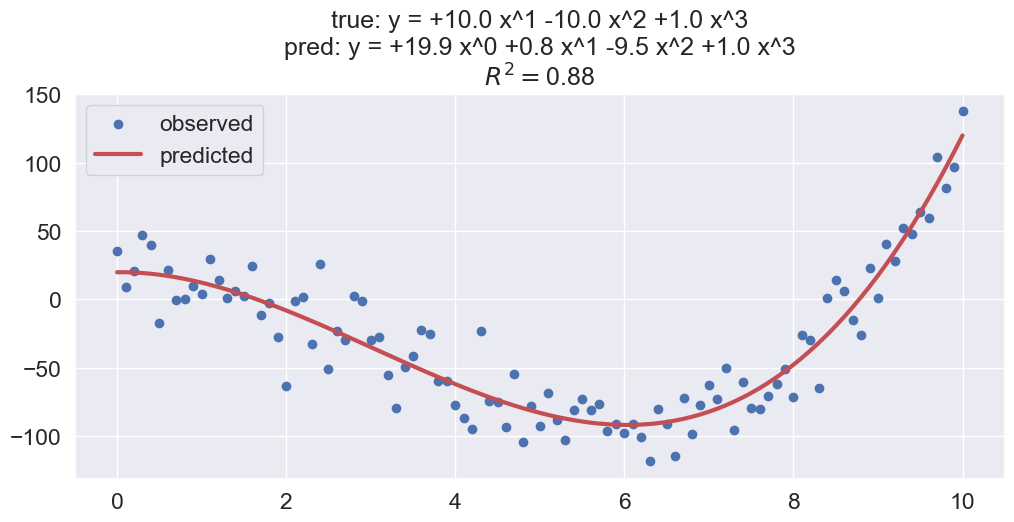

In [42]:
# y = 0 x^0 + 10 x^1 - 10 x^2 + 1 x^3 (no intercept at first)
coef = [0, 10, -10, 1]

# in practice, we can't use the "right" answer (coef above/cubic) because we won't know exactly what the true degree is
# we'll revisit this later.  for now, we'll "cheat" by setting
# degree by peeking at proper answer
tst = len(coef) - 1

# get noisy polynomial data
x, y = get_poly_data(coef)

# process x to polynomial features
poly_feat = PolynomialFeatures(degree=tst)
X_poly = poly_feat.fit_transform(x)

# fit polynomial regression
b = np.matmul(np.linalg.inv(np.matmul(X_poly.T, X_poly)), np.matmul(X_poly.T, y))

# predict y (from regression)
# we'll cross validate later, when we work with real data
y_pred = np.matmul(X_poly, b)

# plot
plt.scatter(x, y, label='observed')
plt.plot(x, y_pred, color='r', linewidth=3, label='predicted')

# getting strs of polynomial (to print)
str_poly_true = coef_to_poly_str(coef)
str_poly_pred = coef_to_poly_str(b)

plt.title(f'true: {str_poly_true}\npred: {str_poly_pred}\n$R^2=${r2_score(y, y_pred):.2f}')

plt.legend()
plt.gcf().set_size_inches(12, 5)

## Let's put this all into a function we can use later....

In [43]:
def fit_plot_poly(x, y, degree):
    """ fits and plots a polynomial of given degree
    
    Args:
        x (np.array): (n_sample, 1) array of x inputs
        y (np.array): (n_sample, 1) array of target values
        degree (int): max degree of polynomial
    """
    
    # project x to polynomial
    poly_project = PolynomialFeatures(degree=degree)
    X_poly = poly_project.fit_transform(x)

    # fit polynomial regression
    b = np.matmul(np.linalg.inv(np.matmul(X_poly.T, X_poly)), np.matmul(X_poly.T, y))
    
    # predict y values (line of polynomial)
    # (we use 101 evenly spaced points as there may be so few
    # observations that the polynomial appears piecewise linear
    # with straight lines between each observation)
    x_fine = np.linspace(x.min(), x.max(), 101).reshape(-1, 1)
    X_fine_poly = poly_project.fit_transform(x_fine)
    y_pred_fine = np.matmul(X_fine_poly, b)
    
    # compute r2
    y_pred = np.matmul(X_poly, b)
    r2 = r2_score(y_true=y, y_pred=y_pred)
    
    # get the predicted line
    str_poly_pred = coef_to_poly_str(b)
    
    # plot polynomial / observations
    plt.plot(x_fine, y_pred_fine, label=f'degree {degree} fit', color='k', linewidth=2)
    plt.title(f'pred: {str_poly_pred}\n$R^2=${r2:.2f}')
    plt.scatter(x, y, label='observed', color='r')
    plt.legend()  
    
    return b

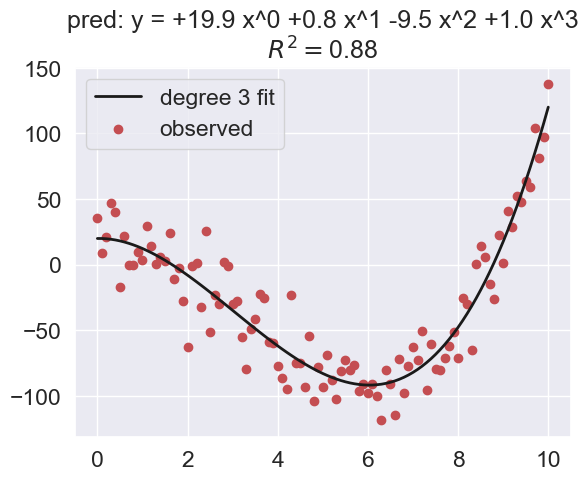

In [44]:
# get noisy polynomial data
x, y = get_poly_data(coef)

#fit_plot_poly(x, y, 0);
#fit_plot_poly(x, y, 1);
#fit_plot_poly(x, y, 2);
fit_plot_poly(x, y, 3);
#fit_plot_poly(x, y, 4);

## In a real problem how do we know what degree to choose?

In our fake data we "cheated" by looking at the real polynomial, represented by `coef`, to determine what degree we should fit the polynomial with:

```python
# degree: what order polynomial should we fit data with?
degree = len(coef) - 1
```

In practice we won't have this luxury ...

### $R^2$ reminder:
- $R^2=1$ implies the line passes through each observation
- $R^2=0$ when the line "ignores" $x$ and is constant at `np.mean(y)`
    - see `degree=0` above
- $R^2<0$ implies the line does a poorer job than the constant estimate `np.mean(y)`
    - this should be very rare, and is only even possible in multiple/polynomial (not simple, unless cross validating) regression

### A good first approach at choosing degree:

**Maybe choosing the polynomial with maximum $R^2$ is a good idea ...**

Spoiler Alert: its not a good idea

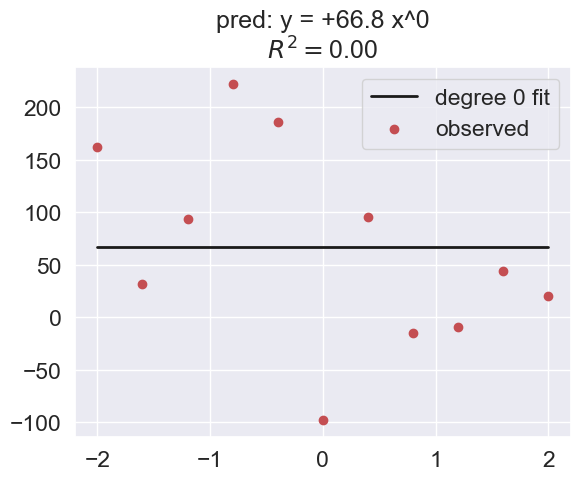

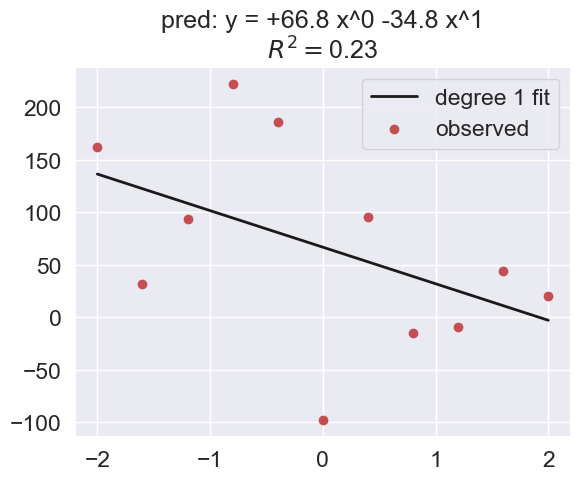

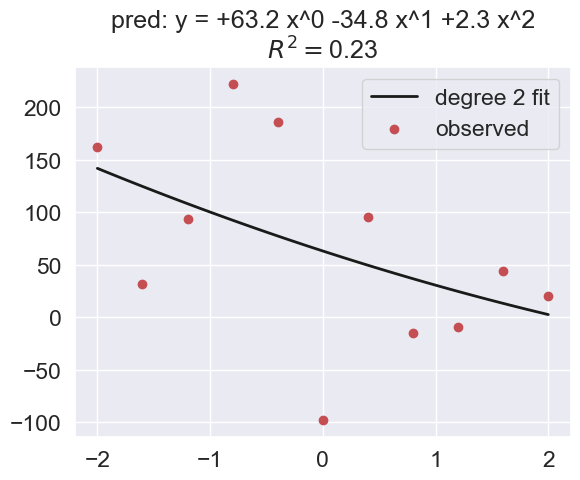

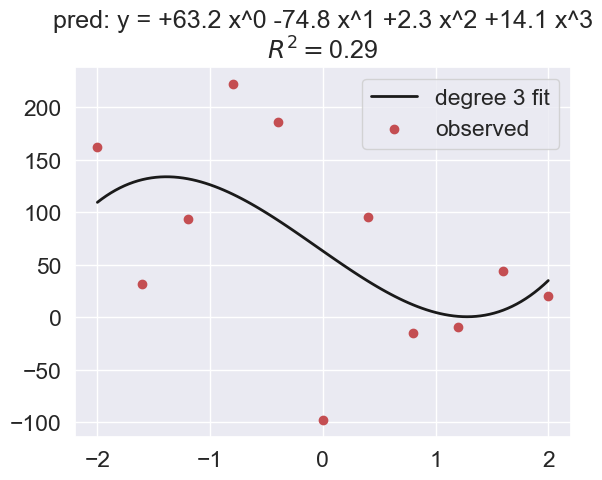

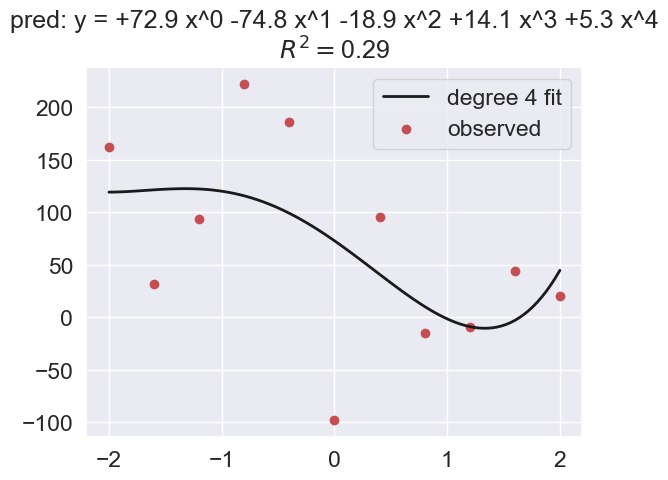

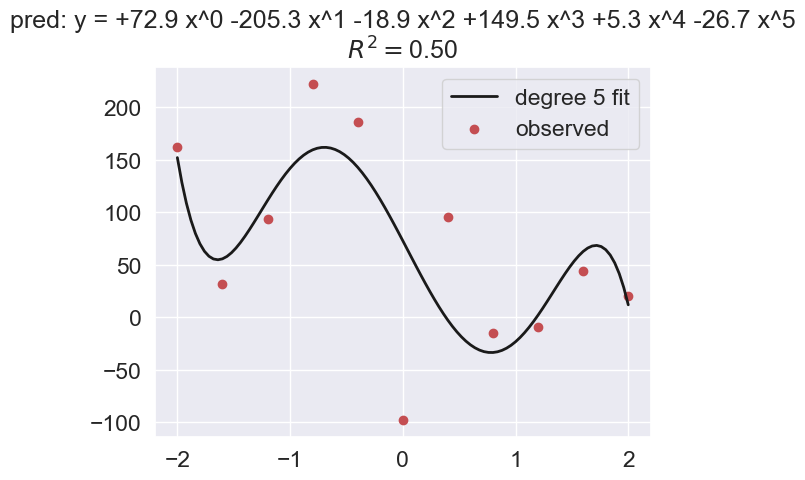

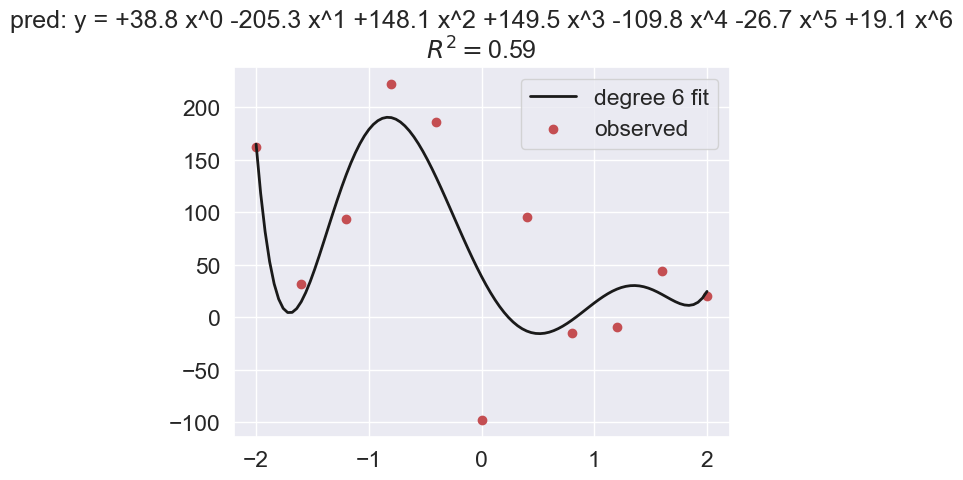

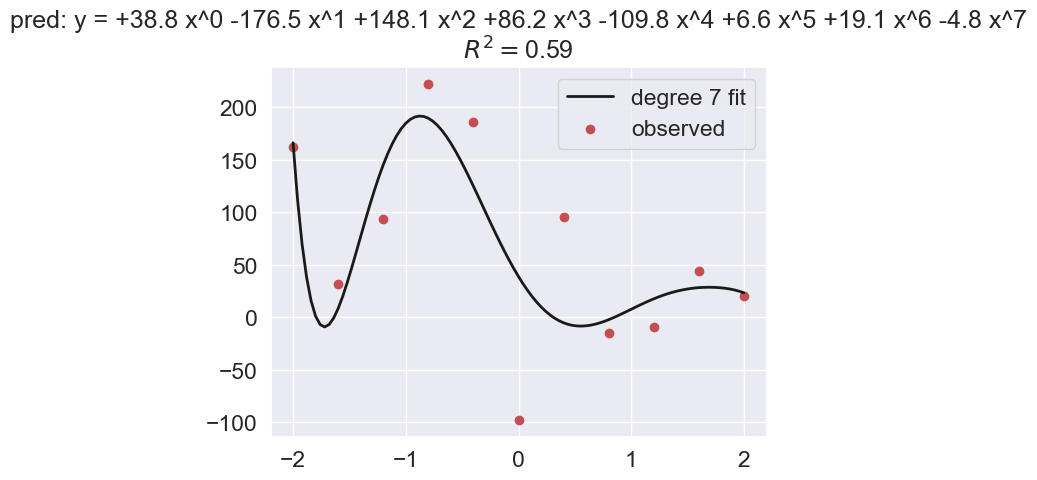

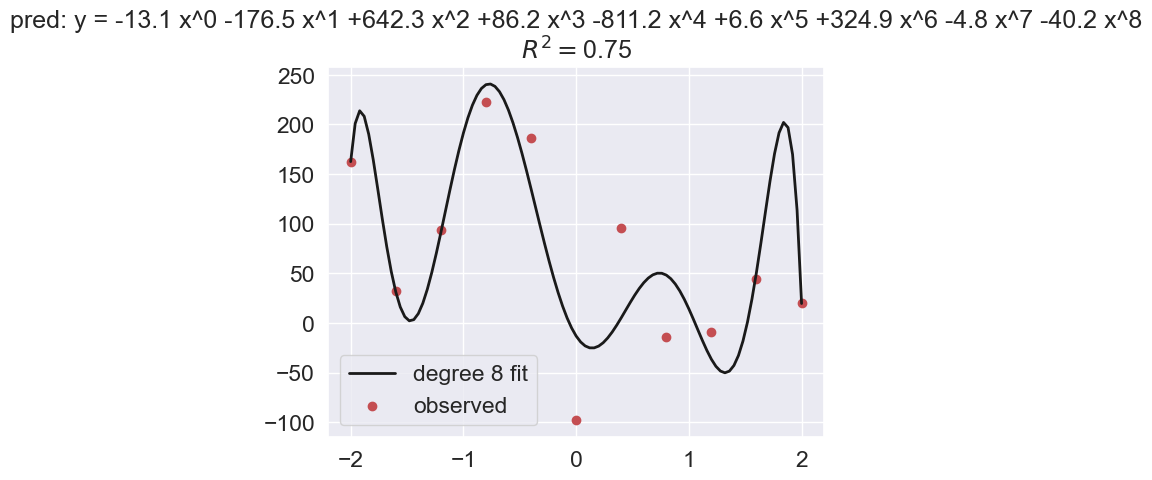

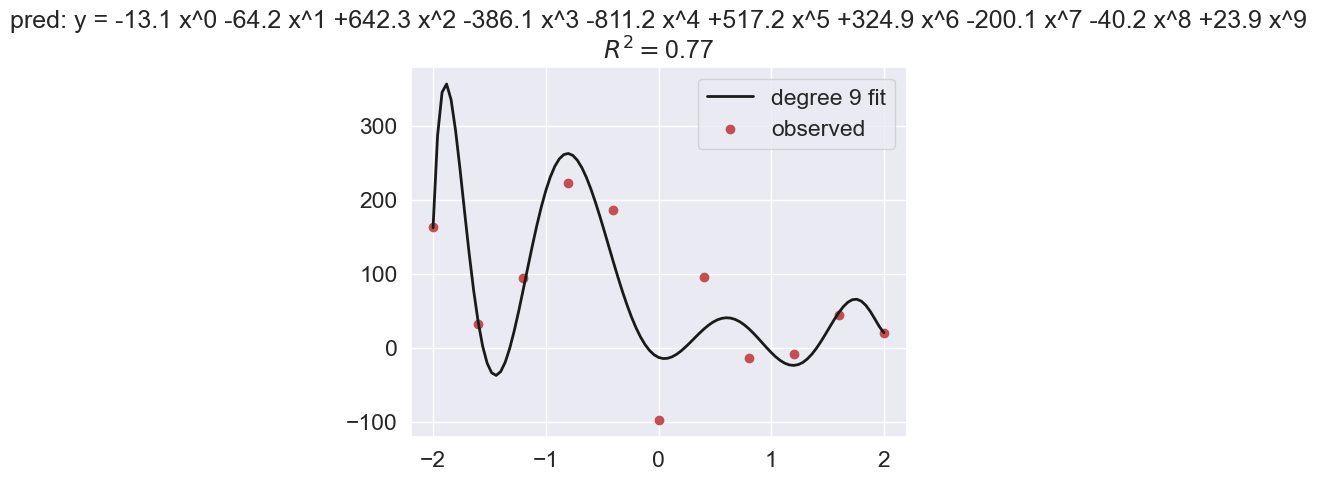

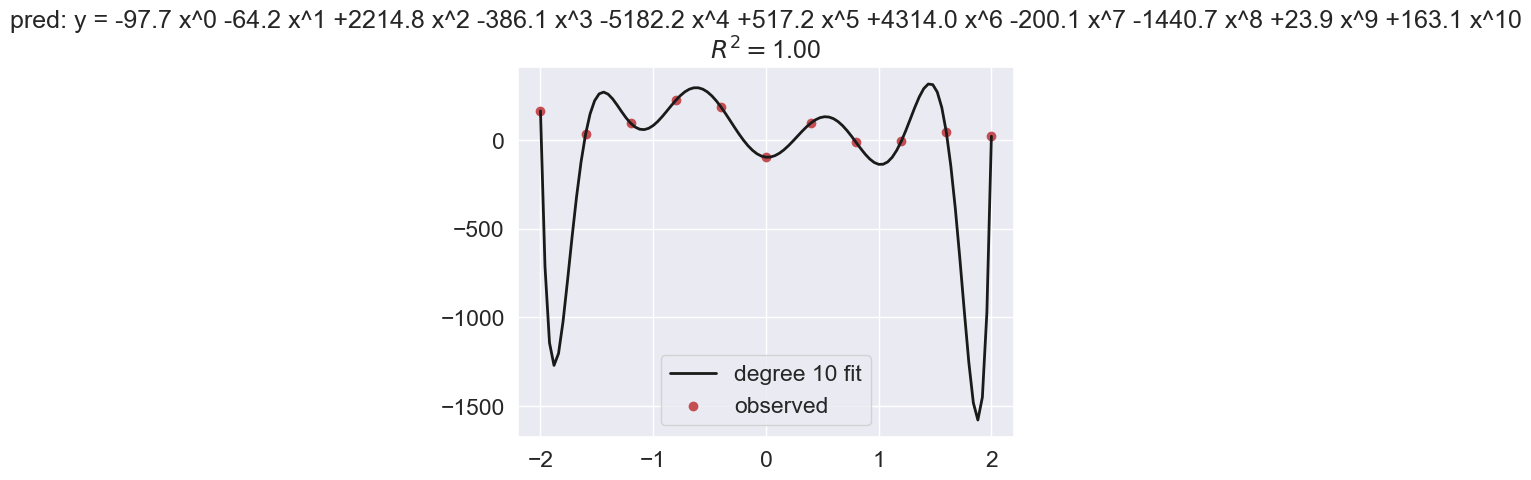

In [45]:
coef = np.array([0, 1, -1, 1])
noise_snr = 100

x, y = get_poly_data(coef, x_start=-2, x_fin=2, n=11, noise=noise_snr)

for degree in range(11):
    # we need a new figure with every plot (so they don't all plot on same figure!)
    plt.figure()

    fit_plot_poly(x, y, degree)

## Takeaway:
**perfect fit:** $R^2 = 1$ and the polynomial touches each sample point

- we can always perfectly fit n points with a polynomial of order n-1.  
    - any 1 point can be fit with a line of form: $\hat{y} = b_0 x^0$
    - any 2 points can be fit with a line of form: $\hat{y} = b_0 x^0 +  b_1 x^1$
    - any 3 points can be fit with a line of form: $\hat{y} = b_0 x^0 +  b_1 x^1 + b_2 x^2$
    - any n points can be fit with a line of form: $\hat{y} = b_0 x^0 +  b_1 x^1 + b_2 x^2 + ... + b_n x^{n-1}$
- increasing polynomial degree will never decrease $R^2$
    - increasing the order is akin to adding feature to the model, these features can never "hurt" the classifier as the corresponding coefficient could be set to zero to remove them if $R^2$ were decreased
 
# Overfitting

What went wrong here?

**Overfitting:** When a model (over)fits the given training data in a way which harms performance on some new, unseen datapoint.  

Overfitting is characterized:
- qualitatively
    - the model looks overly complex
        - given these observations, the dip between the final two data points seems too complex
- quantitatively
    - performance on unseen data is lowered
        - we can use cross validation to measure performance on unseen data
            - ...maybe we could pick a polynomial degree this way

# Preventing overfitting:

|                          |                            Underfitting                            |                            Proper fitting                           |                            Overfitting                            |
|:------------------------:|:------------------------------------------------------------------:|:-------------------------------------------------------------------:|:-----------------------------------------------------------------:|
| Training Set Performance |                                 Bad                                |                                 Good                                |                              Too Good                             |
|  Testing Set Performance |                                 Bad                                |                            About as good                            |                                Bad                                |
|     Model Complexity     |                               Simple                               |                         balanced complexity                         |                           Overly complex                          |
|                          | <img src="https://i.ibb.co/sPTY37G/underfit-poly.png" width=250px> | <img src="https://i.ibb.co/HYGHxvm/justright-poly.png" width=250px> | <img src="https://i.ibb.co/sP76DKd/overfit-poly.png" width=250px> |

In many problems, we are building the classifier / regression model to predict new, unseen samples.  Given this:

**"proper fit" is the model which maximizes the performance on a testing set (e.g. cross validated accuracy or cross validated $R^2$)**

In [46]:
# we'll get our first look at K-fold cross validation (since I'm lazy and did not want to update this function to do LOO-CV specifically)
from sklearn.model_selection import KFold

def cross_val_r2(x, y, degree, n_splits=10):
    """ computes cross validated r2 (regression performance on unseen data)
    
    """
    # project x to polynomial
    poly_project = PolynomialFeatures(degree=degree)
    X_poly = poly_project.fit_transform(x)
        
    # initialize empty y predictions
    y_pred = np.empty_like(y)
    
    # initialize linear regression model
    b = np.matmul(np.linalg.inv(np.matmul(X_poly.T, X_poly)), np.matmul(X_poly.T, y))

    # this implements k-fold cross validation based on the number of splits in the data
    # setting n_splits = number of observations will be LOO-CV
    kfold = KFold(n_splits=n_splits)
    for train_idx, test_idx in kfold.split(X_poly, y):
        # split data
        X_poly_test = X_poly[test_idx, :]
        X_poly_train = X_poly[train_idx, :]
        y_train = y[train_idx]
        
        # fit
        b_train = np.matmul(np.linalg.inv(np.matmul(X_poly_train.T, X_poly_train)), np.matmul(X_poly_train.T, y_train))
        
        # predict
        y_pred[test_idx] = np.matmul(X_poly_test, b_train)
        
    # compute cross validated r2
    r2 = r2_score(y_true=y, y_pred=y_pred)
    
    return r2

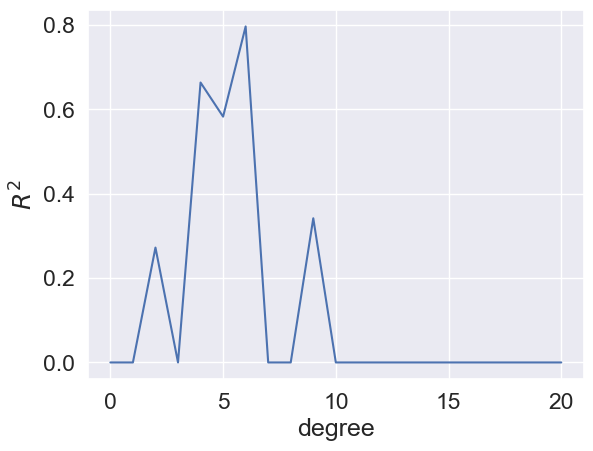

<Figure size 640x480 with 0 Axes>

In [47]:
coef = np.array([0, 0, 0, 0, 1, -1, 1])
noise_snr = 10

# sample noisy data from polynomial
x, y = get_poly_data(coef, x_start=-2, x_fin=2, n=301, noise=noise_snr)

# estimate cv r2 per degree of polynomial
r2_per_degree = list()
for degree in range(21):
    r2 = cross_val_r2(x, y, degree)
    r2_per_degree.append(r2)
    
r2_per_degree = np.maximum(np.array(r2_per_degree), 0)
# r2_per_degree = np.array(r2_per_degree)

    
plt.plot(r2_per_degree)
plt.xlabel('degree')
plt.ylabel(f'$R^2$')
plt.figure();

array([ 1.18718064, -4.90249828, -1.36304044,  4.87329869, -0.0500208 ,
       -2.07824768,  1.4587201 ])

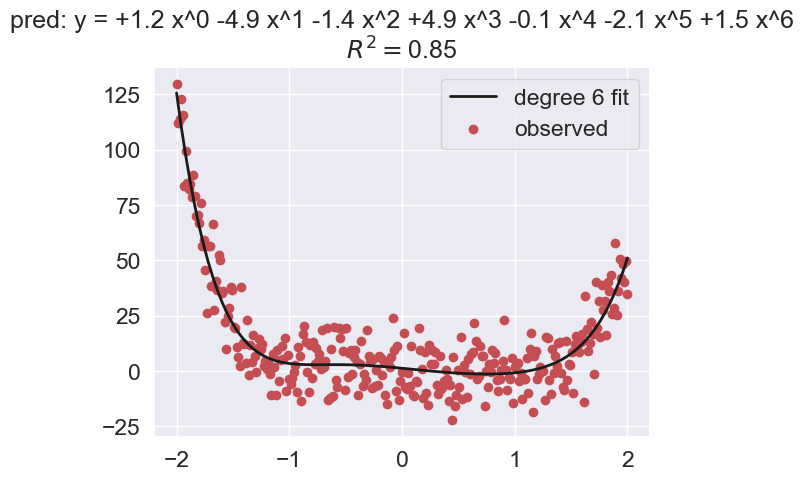

In [48]:
degree_best = np.argmax(r2_per_degree)
fit_plot_poly(x, y, degree_best)

# With Real Data

Recall the electric vehicle data set, and one of our first models; the simple linear regression model predicting `batterycapacity` with `totaltorque`. Here is the scatter plot and then one of the residual plots for that relationship and model:

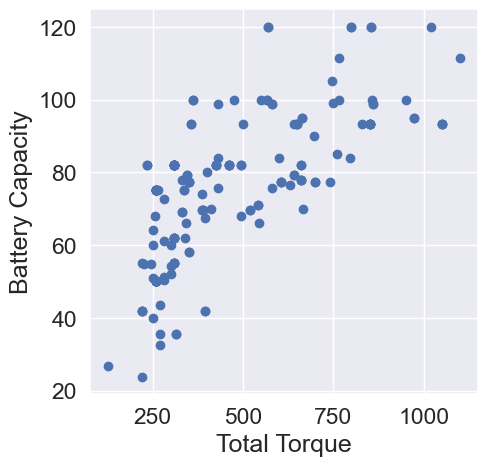

In [49]:
plt.scatter(df_ev.totaltorque, df_ev.batterycapacity)
plt.xlabel('Total Torque')
plt.ylabel('Battery Capacity')
plt.gcf().set_size_inches(5, 5)

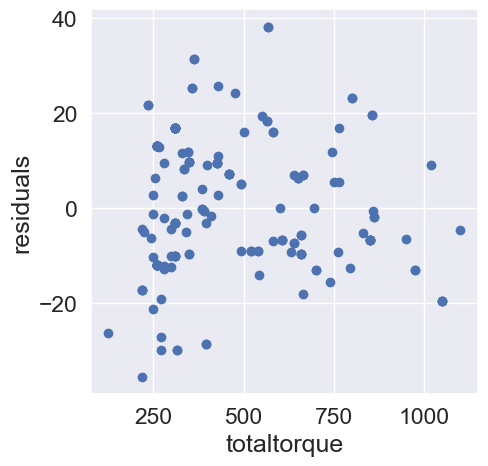

In [50]:
# plot a scatter plot of the errors over x
plt.scatter(x = XB[:,1], y = eB)
plt.xlabel('totaltorque')
plt.ylabel('residuals')
plt.gcf().set_size_inches(5, 5);

You might convince yourself that there is a bit of curve to these points; perhaps a polynomial model will fit these data better than the simple linear regression model? Let's figure that out, using LOO-CV as we did before, however since we don't know **which** polynomial fit would be better, we can use the functions I built above to investigate which order is best. You have to use a bit of subjectivity, however; let's say we don't expect any polynomial over the order of 10 to be useful here...

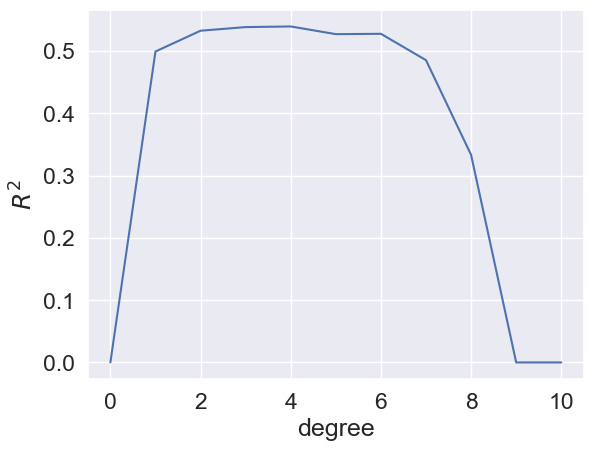

<Figure size 640x480 with 0 Axes>

In [51]:
# while we still have XB[,1] for total torque, we'll need to redefine y after the fake data segue
y = np.array(df_ev.batterycapacity)

# estimate cv r2 per degree of polynomial
r2_per_degree = list()
for degree in range(11):
    # to do LOO-CV, split as many times as there are data points
    r2 = cross_val_r2(XB[:,1].reshape(-1,1), y, degree, n_splits=len(y))
    r2_per_degree.append(r2)
    
r2_per_degree = np.maximum(np.array(r2_per_degree), 0)

plt.plot(r2_per_degree)
plt.xlabel('degree')
plt.ylabel(f'$R^2$')
plt.figure();

array([-48.09717232,   0.72337249,  -0.00156609,   0.00000157,
        -0.        ])

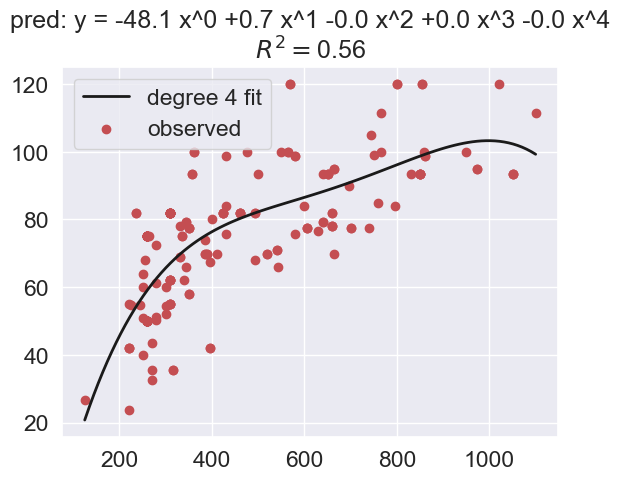

In [52]:
degree_best = np.argmax(r2_per_degree)
fit_plot_poly(XB[:,1].reshape(-1,1), y, degree_best)

Note while this seems to suggest that the 4th degree polynomial is "best", it's hard to say if it's actually much better than the 2nd degree polynomial, though both are even better than the multiple regression model we built that included top speed and drive (look back, that one was .53):

array([24.97681551,  0.153611  , -0.00007889])

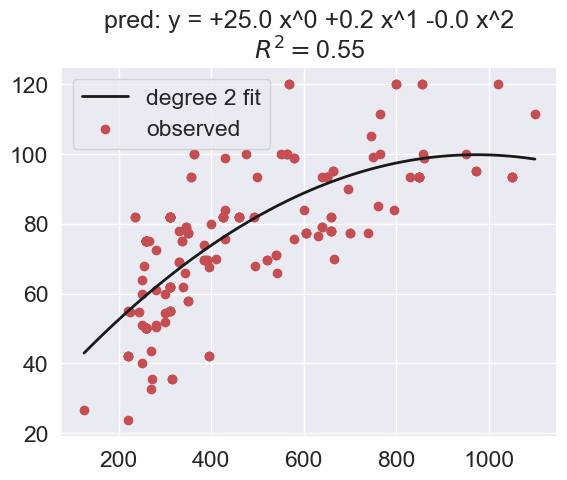

In [53]:
fit_plot_poly(XB[:,1].reshape(-1,1), y, 2)

Which to choose? Once again, you should consider not only $R^2$, but whether the assumptions are met or not, and **especially**, if there is not much difference between a more complicated model and a simpler model, **choose the simpler model**. Simpler models are easier to interpret, easier to implement in the future (with new data), and faster computationally. Of course, if the more complex model gives you a drastic improvement in performance, choose that one, but remember that there is a tradeoff!

Let's just check the assumptions one last time to verify that the quadratic model makes sense for these data. We can go ahead and use the full data set to check:

In [54]:
poly_again = PolynomialFeatures(2)
X_poly_tt = poly_again.fit_transform(XB[:,1].reshape(-1,1))

# examine polynomial features
X_poly_tt[0:4]

array([[     1.,    350., 122500.],
       [     1.,    520., 270400.],
       [     1.,    850., 722500.],
       [     1.,    430., 184900.]])

In [55]:
# do the thing
b = np.matmul(np.linalg.inv(np.matmul(X_poly_tt.T, X_poly_tt)), np.matmul(X_poly_tt.T, y))
b

array([24.97681551,  0.153611  , -0.00007889])

In [56]:
y_preds = np.matmul(X_poly_tt, b)
residuals = y - y_preds

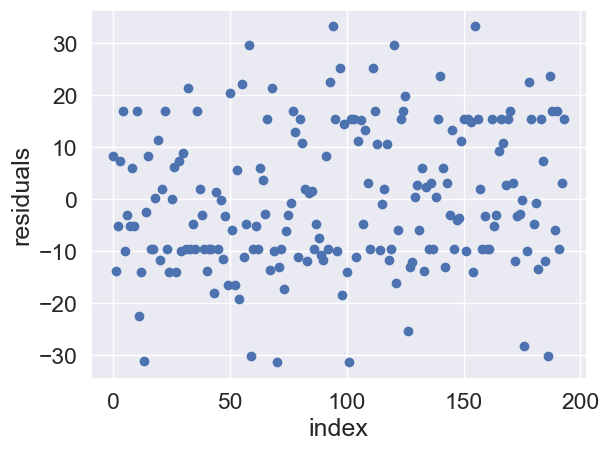

In [57]:
# plot a scatter plot of the errors in order
plt.scatter(x = range(len(y)), y = residuals)
plt.xlabel('index')
plt.ylabel('residuals');

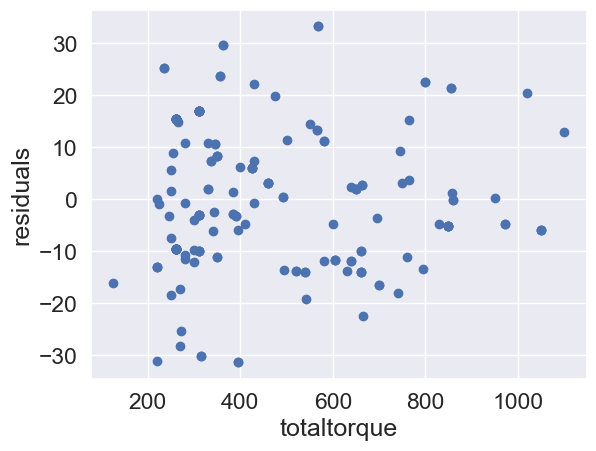

In [58]:
# plot a scatter plot of the errors over x
plt.scatter(x = XB[:,1], y = residuals)
plt.xlabel('totaltorque')
plt.ylabel('residuals');

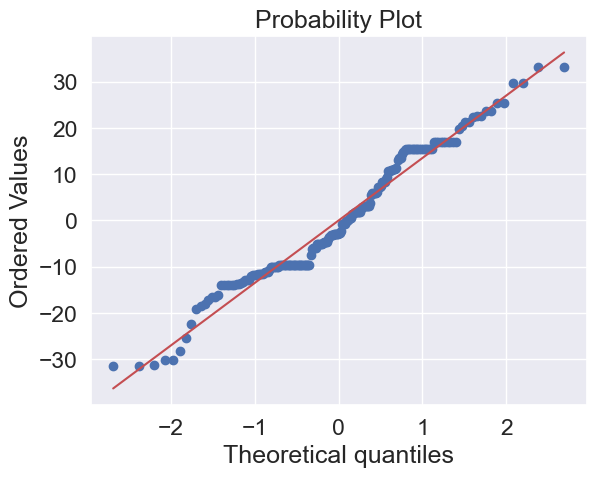

In [59]:
# the normal probability plot
stats.probplot(residuals, dist="norm", plot=py)
py.show()

Do these look any better/worse than the plots for the simple linear regression? I'd argue the first plots look about the same, the second plot looks a little bit better, and the third plot looks a little bit worse. This is one of those situations where there may not be a clear answer! This can (and does) happen quite often. It is at this point that it helps to be an expert in the application field or, if you're not (which is likely), to have access to an expert you can discuss the results with. Find someone who knows about electric vehicles and ask them about whether it makes sense for total torque to impact battery capacity linearly or quadratically, or if they would expect even some other shape (i.e. does the quartic actually make the most sense?).

## Practice (if time)

For the `hank_aaron_hr.csv` dataset on Canvas:
1. regress `age` & `HRR`
    - this gives baseball player Hank Aarons Home Run Rate over his career by age
1. use cross validation to find the best polynomial fit for the model (test degree `0` through `10`)
    - use `n_splits=23` (LOO-CV)
1. plot the best fit line over the points for that polynomial fit of all the data and calculate the $R^2$
1. check the assumptions (independence, constant variance, and normality)

In [60]:
df_aaron = pd.read_csv('hank_aaron_hr.csv')
df_aaron.head()

Unnamed: 0   playerID  age   AB  HR       HRR
0          10  aaronha01   26  590  40  0.067797
1          11  aaronha01   31  570  32  0.056140
2          12  aaronha01   20  468  13  0.027778
3          13  aaronha01   27  603  34  0.056385
4          14  aaronha01   34  606  29  0.047855

## This is the point where we've covered everything on the Homeworks. Everything after this is simply diving in a little deeper/extending the ideas and combining everything.

## Combining Everything

There is also no reason why you couldn't **combine** polynomial features with multiple regression. For example, suppose we wanted to bring in `drive` into this quadratic regression model. We can do that! The model becomes, in long form:

$$\hat{y} = b_0 + b_1x_1 + b_2x_1^2 + b_3x_2 + b_4x_3$$

Where $x_1$ is total torque, brought in quadratically, and $x_2$ and $x_3$ represent the indicator/dummy variables for `front` and `rear` wheel drive as before. Our design matrix is now:

In [61]:
X_combo = np.hstack((X_poly_tt, drive_x))
X_combo[0:4,]

array([[     1.,    350., 122500.,      0.,      1.],
       [     1.,    520., 270400.,      0.,      0.],
       [     1.,    850., 722500.,      0.,      0.],
       [     1.,    430., 184900.,      0.,      1.]])

Note that because I only have one numeric $x$ feature, I don't have to scale. However, **if you brought in more numeric $x$ features, you should scale them all, including the polynomial terms!! (we'll do this in a moment)**.

In [62]:
# do the thing
b = np.matmul(np.linalg.inv(np.matmul(X_combo.T, X_combo)), np.matmul(X_combo.T, y))
b

array([16.74632372,  0.16334802, -0.00007907,  3.10690116, 11.58864475])

## Interpretation

Now we have to combine our interpretation of multiple and polynomial regression. Because we have a categorical feature, there is now a "baseline" of `AWD` again; so the intercept is the predicted battery capacity for an `AWD` vehicle when total torque is zero (as in multiple regression). The rest of the multiple regression interpretation stays the same, including how we interpret the quadratic term:

- the quadratic term of -.00007 is how the square of total torque impacts battery capacity holding drive fixed

How does this model perform? Since we don't need those nice functions for plotting curves anymore, we can do it the way we did it before:

In [63]:
# set up the array of predictions to fill out
y_preds_combo = np.empty(len(X_combo))

# loop through each observation
for obs in range(len(X_combo)):
    # the below excludes the single row/true y belonging to obs as well as the bias column
    mult_trainX = np.concatenate((X_combo[:obs, 1:], X_combo[obs+1:, 1:]))
    mult_trainy = np.concatenate((y[:obs], y[obs+1:]))
    # then train the model
    loocv_regress = LinearRegression()
    loocv_regress.fit(mult_trainX, mult_trainy)
    # and predict the held out observation (and store it)
    y_preds_combo[obs] = loocv_regress.predict(X_combo[obs,1:].reshape(-1,4))[0]

r2_score(y, y_preds_combo)

0.5621886591960102

That's the best cross validated $R^2$ yet! Of course, we could see if including more features, like top speed (or even others!), help improve it more, but remember that the more predictors you add, the better $R^2$ is guaranteed to be, so we usually like to look at adjusted $R^2$ instead (and never forget that if you add **too many**, you will eventually not only overfit, but also run into identifiability issues):

In [64]:
# let's add a couple more features as well, like electricrange and chargespeed
# need to scale them
scale_erange = (df_ev.electricrange/df_ev.electricrange.std()).to_numpy()
scale_cspeed = (df_ev.chargespeed/df_ev.chargespeed.std()).to_numpy()
X_full = np.hstack((np.array([1]*len(y)).reshape(-1,1), 
                    scale_torque.reshape(-1,1), 
                    (scale_torque**2).reshape(-1,1), 
                    scale_tspeed.reshape(-1,1),
                    scale_erange.reshape(-1,1),
                    scale_cspeed.reshape(-1,1),
                    drive_x))
X_full[0:4,]

array([[ 1.        ,  1.57500568,  2.48064289,  4.85434176,  3.84674653,
         3.13742199,  0.        ,  1.        ],
       [ 1.        ,  2.34000844,  5.4756395 ,  4.19834963,  3.25493937,
         2.94533493,  0.        ,  0.        ],
       [ 1.        ,  3.8250138 , 14.63073054,  6.82231815,  4.09333285,
         2.94533493,  0.        ,  0.        ],
       [ 1.        ,  1.93500698,  3.74425201,  4.98554018,  4.63582274,
         3.45756709,  0.        ,  1.        ]])

In [65]:
# do the thing
b = np.matmul(np.linalg.inv(np.matmul(X_full.T, X_full)), np.matmul(X_full.T, y))
b

array([21.67497103, 10.87545338, -0.64879871, -3.16188409, 18.19856677,
       -5.26388061,  3.72305095, -0.13463317])

In [66]:
# set up the array of predictions to fill out
y_preds_full = np.empty(len(X_full))

# loop through each observation
for obs in range(len(X_full)):
    # the below excludes the single row/true y belonging to obs as well as the bias column
    mult_trainX = np.concatenate((X_full[:obs, 1:], X_full[obs+1:, 1:]))
    mult_trainy = np.concatenate((y[:obs], y[obs+1:]))
    # then train the model
    loocv_regress = LinearRegression()
    loocv_regress.fit(mult_trainX, mult_trainy)
    # and predict the held out observation (and store it)
    y_preds_full[obs] = loocv_regress.predict(X_full[obs,1:].reshape(-1,7))[0]

# cross validated r2
r2_score(y, y_preds_full)

0.8597986521699288

In [67]:
# to get full r2 and adjusted r2
new_model = sm.OLS(y, X_full).fit()

#display line and regular R2 (to verify same as before) and adjusted R-squared
print(new_model.params)
print(new_model.rsquared)
print(new_model.rsquared_adj)

[21.67497103 10.87545338 -0.64879871 -3.16188409 18.19856677 -5.26388061
  3.72305095 -0.13463317]
0.8712602271378486
0.8664151819226062


As always, before we can say that this model is the best model in the world for predicting battery capacity (an adjusted $R^2$ of about 86\% is good!), we should check our assumptions and make sure there are no gross violations. Using the cross validated predictions:

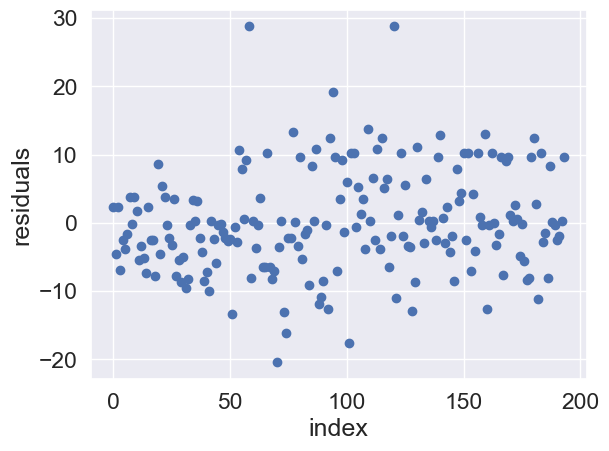

In [68]:
residuals = y - y_preds_full

# plot a scatter plot of the errors in order
plt.scatter(x = range(len(y)), y = residuals)
plt.xlabel('index')
plt.ylabel('residuals');

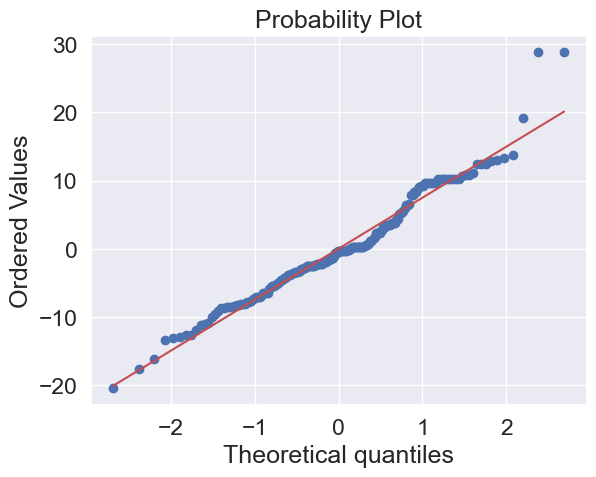

In [69]:
# do this first because there are a lot more residual plots than usual
# the normal probability plot
stats.probplot(residuals, dist="norm", plot=py)
py.show()

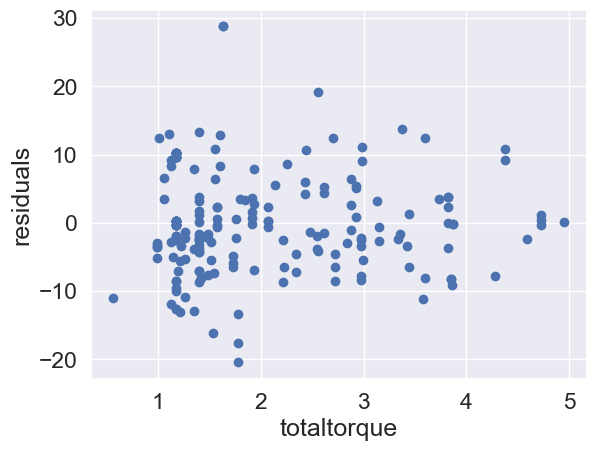

In [70]:
# there are lot's of x features now! Will take a while to look through all the plots, but it is important to do so
# it might show us that we should have had polynomial terms for more than just total torque!
# plot a scatter plot of the errors over total torque (don't have to do this for the squared term)
plt.scatter(x = X_full[:,1], y = residuals)
plt.xlabel('totaltorque')
plt.ylabel('residuals');


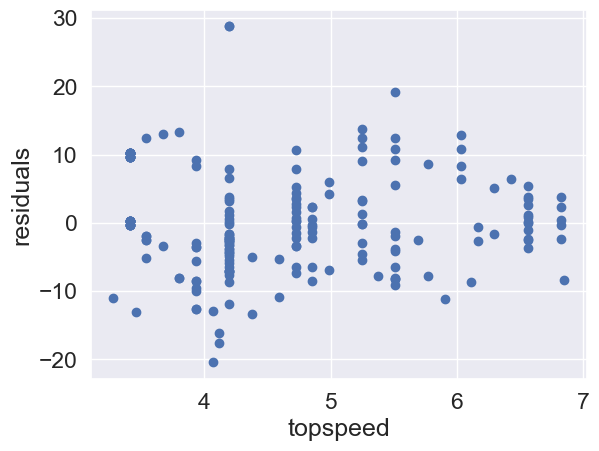

In [71]:
# plot a scatter plot of the errors over top speed
plt.scatter(x = X_full[:,3], y = residuals)
plt.xlabel('topspeed')
plt.ylabel('residuals');

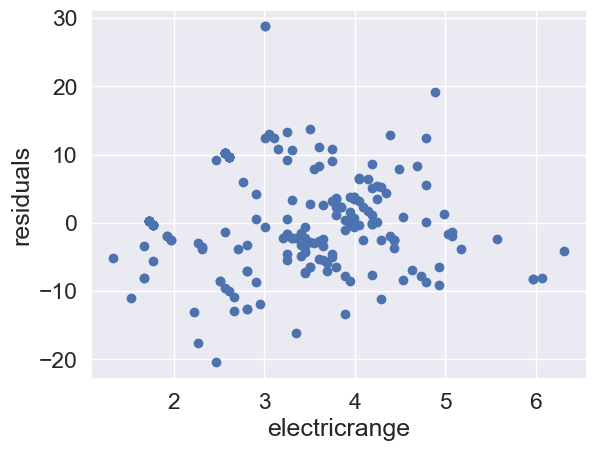

In [72]:
# plot a scatter plot of the errors over electric range
plt.scatter(x = X_full[:,4], y = residuals)
plt.xlabel('electricrange')
plt.ylabel('residuals');

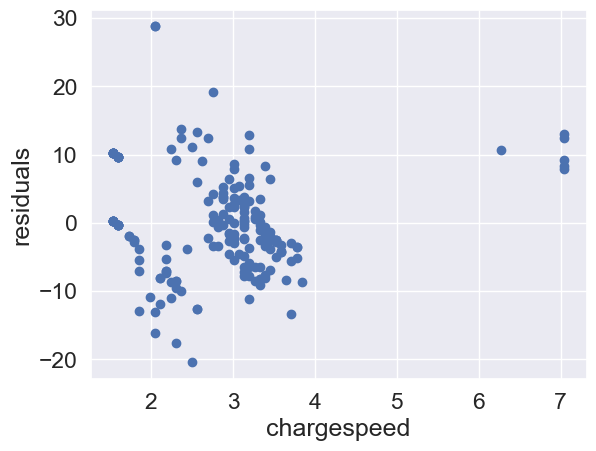

In [73]:
# plot a scatter plot of the errors over charge speed
plt.scatter(x = X_full[:,5], y = residuals)
plt.xlabel('chargespeed')
plt.ylabel('residuals');

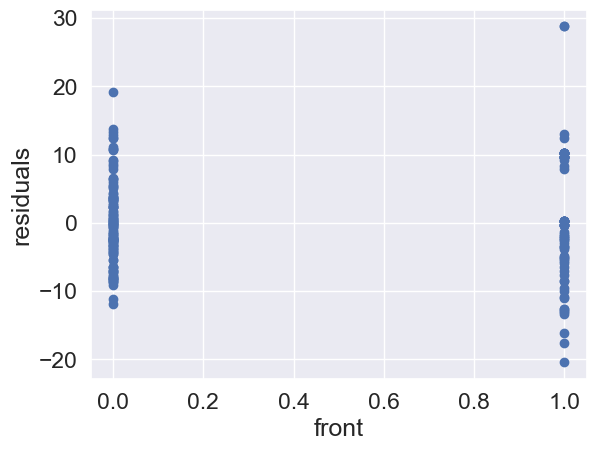

In [74]:
# plot a scatter plot of the errors over front wheel drive
plt.scatter(x = X_full[:,6], y = residuals)
plt.xlabel('front')
plt.ylabel('residuals');

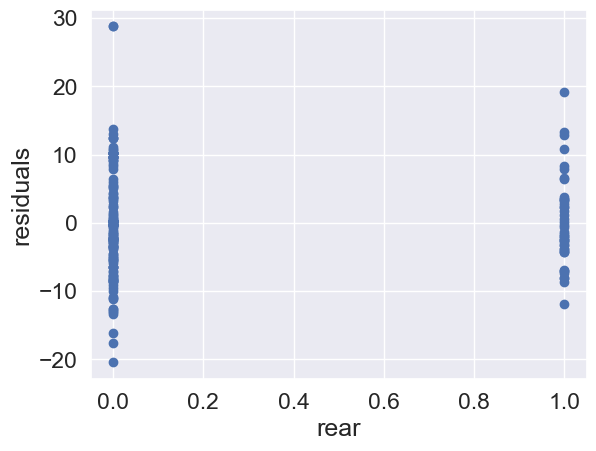

In [75]:
# plot a scatter plot of the errors over rear wheel drive
plt.scatter(x = X_full[:,7], y = residuals)
plt.xlabel('rear')
plt.ylabel('residuals');

## "Concluding" everything

It can be a bit daunting to consider everything in a big complex model like this, with categorical features, multiple $x$'s, *and* polynomial terms. It is important to compartmentalize, and also to not get bogged down in too many fine points. There are likely a couple things remaining to address before we can call this our "final" model, but we're pretty close to having something that is trustworthy for predicting battery capacity! The things left to do are likely:

- Investigate the two large residual outliers (visible in the first two plots)
- Investigate the strange shapes/clusters in the charge speed residual plot (and those relatively few vehicles with large charge speed ~7)
- Perhaps investigate including even more features:
    - though doing so will make the model more complex, it's possible there may be a feature we have ignored that will drastically improve our model further (both in terms of $R^2$ and in terms of meeting the assumptions). Technically, we should employ more rigorous **model selection**, but this is a much longer process than what we've been developing in class. You start the process by including polynomial terms for those features it seems appropriate to, and including *interactions* between as many features as seems appropriate given the data, then you would go through a step-wise process of backwards elimination of terms which do not improve adjusted $R^2$ or do not seem important. **THEN**, you do it all again in reverse, (sort of as we've been doing) adding terms sequentially, squaring terms as needed, including interactions until adjusted $R^2$ stops improving by a certain amount.
    - it's complicated.

## Looking Ahead

Depending on how long it takes us to get through this notebook, we'll have 1-2 class periods to briefly introduce Neural Networks.